In [1]:
import pandas as pd
import ptitprince as pt
import numpy as np
import scipy.io
import scipy.stats as stats
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy.matlib
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

In [2]:
selected_subjects = range(8,27)
excluded_subjects = [13, 14]
selected_subjects = list(set(selected_subjects).symmetric_difference(excluded_subjects))
number_of_subjects = len(selected_subjects)

In [3]:
root_directory = '../data'
hemispheres = ['lh', 'rh']
regressors_of_interest = [
    'Stimulus_{Right,On}',
    'Stimulus_{Left,On}',
    'Stimulus_{Right,Off}',
    'Stimulus_{Left,Off}'
];
layers = ['Deep', 'Middle', 'Top']
regions = ['V1', 'V2', 'V3']

color_palletes = {}
color_palletes['V1'] = ["#ff0000", "#0000ff", "#ff0000", "#0000ff"]
color_palletes['V2'] = ["#ff4000", "#0066ff", "#ff4000", "#0066ff"]
color_palletes['V3'] = ["#ff8000", "#0094ff", "#ff8000", "#0094ff"]

In [4]:
def make_figure(method, N, region, plot=True, nLayers=3):
    if nLayers == 3:
        layers = ['Deep', 'Middle', 'Top']
    else:
        layers = ['Deep', 'Middle - 1', 'Middle - 2', 'Top']

    results = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
    number_of_layers = nLayers + 2;

    betas = {}
    betas['rh'] = np.zeros((number_of_subjects, number_of_layers, len(regressors_of_interest)))
    betas['lh'] = np.zeros((number_of_subjects, number_of_layers, len(regressors_of_interest)))
    for subject in range(len(selected_subjects)):
        for hemisphere in hemispheres:
            design_matrix = np.empty((0,0))
            regressors = []
            time_course = []
            for chunk in range(1,4):
                subject_directory = '{:s}/SubjectData/Subject{:02d}/Set{:d}'.format(
                    root_directory, selected_subjects[subject], chunk
                )
                design_file = '{:s}/DesignMatrix/DesignStimulus.mat'.format(subject_directory);
                if not os.path.isfile(design_file):
                    continue

                mat = scipy.io.loadmat(design_file)
                d = mat['design']['DesignMatrix'][0,0]
                r = mat['design']['RegressorLabel'][0,0]
                design_matrix = np.concatenate((
                    np.concatenate((design_matrix, np.zeros((d.shape[0], design_matrix.shape[1]))), axis=0),
                    np.concatenate((np.zeros((design_matrix.shape[0], d.shape[1])), d), axis=0)),
                axis=1)
                regressors += [i[0][0] for i in np.transpose(r)]
                design_matrix = pd.DataFrame(data=design_matrix, columns=regressors)
                
                if nLayers == 4:
                    timecourse_file ='{:s}/TimeCourses/{:s}.{:s}patch_{:d}vertices_4.mat'.format(
                        subject_directory, hemisphere, region, N
                    )
                else:
                    timecourse_file ='{:s}/TimeCourses/{:s}.{:s}_{:d}v_{:s}.mat'.format(
                        subject_directory, hemisphere, region, N, method
                    )
                mat = scipy.io.loadmat(timecourse_file)
                time_course += [i[0] for i in mat['timeCourses']]

            time_course = np.concatenate((time_course), axis=1)
            model = LinearRegression(fit_intercept=False)
            model.fit(design_matrix, np.transpose(time_course))
            b = pd.DataFrame(model.coef_, columns=regressors)

            for regressor in range(len(regressors_of_interest)):
                percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
                mean_over_runs = np.mean(percent_signal_change, 1)
                betas[hemisphere][subject,:,regressor] = mean_over_runs
                
                
                if regressor == 0: # 'Stimulus_{Right,On}':
                    stimulus = 'On'
                    if hemisphere == 'lh':
                        attention = 'On'
                    else:
                        attention = 'Off'
                elif regressor == 1: # 'Stimulus_{Left,On}':
                    stimulus = 'On'
                    if hemisphere == 'lh':
                        attention = 'Off'
                    else:
                        attention = 'On'
                elif regressor == 2: #'Stimulus_{Right,Off}':
                    stimulus = 'Off'
                    if hemisphere == 'lh':
                        attention = 'On'
                    else:
                        attention = 'Off'
                elif regressor == 3: #'Stimulus_{Left,Off}':
                    stimulus = 'Off'
                    if hemisphere == 'lh':
                        attention = 'Off'
                    else:
                        attention = 'On'
                
                for l in range(nLayers):  
                    results = results.append({'Activation': mean_over_runs[l + 1], 'Subject': subject, 'Stimulus': stimulus, 'Attention': attention, 'Layer': layers[l], 'Hemisphere': hemisphere, 'Area': region}, ignore_index=True)
  
    ax = []
    if plot:
        yv, xv = np.meshgrid(layers, regressors_of_interest)
        layer_labels    = np.matrix.flatten(np.transpose(numpy.matlib.repmat(np.matrix.flatten(yv), number_of_subjects, 1)))
        stimulus_labels = np.matrix.flatten(np.transpose(numpy.matlib.repmat(np.matrix.flatten(xv), number_of_subjects, 1)))

        data = (betas['rh'][:,1:(nLayers+1),(1,0,3,2)] + betas['lh'][:,1:(nLayers+1),(0,1,2,3)]) / 2
        data = pd.DataFrame(np.matrix.flatten(np.transpose(data, (2,1,0))), columns=['Activation'])
        data['Task'] = stimulus_labels
        data['Layer'] = layer_labels

        dx   = "Layer"; 
        dy   = "Activation"; 
        dhue = "Task"
        pal  = sns.color_palette(color_palletes[region])

        plt.figure()
        ax = pt.RainCloud(
            data       = data, 
            x          = dx, 
            y          = dy,
            hue        = dhue, 
            palette    = pal, 
            bw         = .4, 
            width_viol = .5,
            figsize    = (12,5), 
            orient     = 'v' , 
            alpha      = .6, 
            dodge      = True, 
            pointplot  = True, 
            move       = 0.1    
        )
        ax.set_ylim(-0.03, 0.1)
        ax.set_yticks([x * 0.02 for x in range(-1, 6, 1)])
        ax.set_yticklabels(['{:,.1%}'.format(x * 0.02) for x in range(-1, 6, 1)])

        plt.title("Layer Activation in {:s}, ROI of {:d} vertices, signal extracted with {:s}".format(region, N, method))
        plt.savefig(f'./img/{N}Vertices/{region}_{method}_{nLayers}layers.png', bbox_inches='tight')
        plt.savefig(f'./img/{N}Vertices/{region}_{method}_{nLayers}layers.pdf', bbox_inches='tight')
        
    return [results, ax]

Some plot styling functions:

In [5]:
def color_significant_values(value):
    if value > 0.05:
        color = "black"
    elif value > 0.01:
        color = 'darkred'
    else:
        color = 'green'
    return 'color: %s' % color

def bold_face(value):
    return 'font-weight: bold'

### Main statistical layer analysis:

In [6]:
betas = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
for region in regions:
    [a, _] = make_figure('OLS', 600, region, plot=False)
    betas = betas.append(a)

# Export data to CSV to reanalyse in JASP, on reviewer's request



warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-7ccd54aea93d>:53: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-4-7ccd54aea93d>:53: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Seri

In [7]:
pivot = pd.pivot_table(betas, values='Activation', index=['Subject'], columns=['Stimulus', 'Attention', 'Layer', 'Area'], aggfunc=np.mean)

columns = []
for col in pivot.columns:
    stim = "+" if col[0] == "On" else "-"
    att = "+" if col[1] == "On" else "-"
    lay = 1 if col[2] == "Deep" else 2 if col[2] == "Middle" else 3 
    columns.append(f"S{stim}_A{att}_L{lay}_{col[3]}")

pd.DataFrame(pivot.values, columns=columns).to_csv("../data/processed/layer-betas.csv", index=False)


In [8]:


aov_table = AnovaRM(betas, 'Activation', 'Subject', within=['Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
res = aov_table.fit()

hemipshere_string = 'Hemisphere'
rows = res.summary().tables[0].index.values
selected_rows = [str for str in rows if hemipshere_string not in str];
selected_rows.insert(4, hemipshere_string)

pd.DataFrame(res.summary().tables[0]) \
    .loc[selected_rows,:] \
    .style \
    .applymap(color_significant_values, subset=['Pr > F']) \
    .format({'F Value': "{:.3f}", 'Num DF': "{:.0f}", 'Den DF': "{:.0f}", 'Pr > F': "{:.4e}"})

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

### Exploration of significant effects:

The significant Area X Layer X Stimulus interaction means that the Layer X Stimulus interactions are not (statistically) equal per area. So let's take a look at the area-specific slopes:

In [15]:
betas.groupby(['Subject', 'Area', 'Layer', 'Stimulus']).mean()
a = betas.groupby(['Subject', 'Area', 'Layer', 'Stimulus']).mean()
b = a.query(f"Stimulus == 'On'").reset_index(level='Stimulus', drop=True) - a.query(f"Stimulus == 'Off'").reset_index(level='Stimulus', drop=True)

slopes_stim = {};
for region in regions:
    stim_layer_interactions = b.query(f"Area == '{region}'");
    # linear least squares fit slope = (y_2 - y_0) / 2
    slopes_stim[region] = (stim_layer_interactions.query(f"Layer == 'Top'").reset_index(level='Layer', drop=True) - stim_layer_interactions.query(f"Layer == 'Deep'").reset_index(level='Layer', drop=True));

    
lay_stim_interaction = pd.DataFrame(columns=['Areas', 'tvalue', 'pvalue'])
test = stats.ttest_rel(slopes_stim['V1'], slopes_stim['V2'])
lay_stim_interaction.loc[len(lay_stim_interaction)] = {'Areas': 'V1-V2', 'tvalue': test.statistic[0], 'pvalue': test.pvalue[0]}
test = stats.ttest_rel(slopes_stim['V1'], slopes_stim['V3'])
lay_stim_interaction.loc[len(lay_stim_interaction)] = {'Areas': 'V1-V3', 'tvalue': test.statistic[0], 'pvalue': test.pvalue[0]}
test = stats.ttest_rel(slopes_stim['V2'], slopes_stim['V3'])
lay_stim_interaction.loc[len(lay_stim_interaction)] = {'Areas': 'V2-V3', 'tvalue': test.statistic[0], 'pvalue': test.pvalue[0]}

lay_stim_interaction


,Areas,tvalue,pvalue
0,V1-V2,2.262271,0.037952
1,V1-V3,1.348635,0.196235
2,V2-V3,-1.431445,0.171546


The significant Area X Layer X Attention interaction means that the Layer X Attention interactions are not (statistically) equal per area. So let's take a look at the area-specific slopes:

In [16]:
betas.groupby(['Subject', 'Area', 'Layer', 'Attention']).mean()
a = betas.groupby(['Subject', 'Area', 'Layer', 'Attention']).mean()
b = a.query(f"Attention == 'On'").reset_index(level='Attention', drop=True) - a.query(f"Attention == 'Off'").reset_index(level='Attention', drop=True)

slopes_att = {};
for region in regions:
    stim_layer_interactions = b.query(f"Area == '{region}'");
    # linear least squares fit slope = (y_2 - y_0) / 2
    slopes_att[region] = (stim_layer_interactions.query(f"Layer == 'Top'").reset_index(level='Layer', drop=True) - stim_layer_interactions.query(f"Layer == 'Deep'").reset_index(level='Layer', drop=True));

    
lay_att_interaction = pd.DataFrame(columns=['Areas', 'tvalue', 'pvalue'])
test = stats.ttest_rel(slopes_att['V1'], slopes_att['V2'])
lay_att_interaction.loc[len(lay_att_interaction)] = {'Areas': 'V1-V2', 'tvalue': test.statistic[0], 'pvalue': test.pvalue[0]}
test = stats.ttest_rel(slopes_att['V1'], slopes_att['V3'])
lay_att_interaction.loc[len(lay_att_interaction)] = {'Areas': 'V1-V3', 'tvalue': test.statistic[0], 'pvalue': test.pvalue[0]}
test = stats.ttest_rel(slopes_att['V2'], slopes_att['V3'])
lay_att_interaction.loc[len(lay_att_interaction)] = {'Areas': 'V2-V3', 'tvalue': test.statistic[0], 'pvalue': test.pvalue[0]}

lay_att_interaction


,Areas,tvalue,pvalue
0,V1-V2,0.139906,0.890480
1,V1-V3,-0.883422,0.390090
2,V2-V3,-1.675922,0.113181


Let's inspect the attention slopes to the stimulus slopes:

In [17]:
stim = (slopes_stim['V1']['Activation'].values + slopes_stim['V2']['Activation'].values + slopes_stim['V3']['Activation'].values) / 3
att = (slopes_att['V1']['Activation'].values + slopes_att['V2']['Activation'].values + slopes_att['V3']['Activation'].values) / 3

stats.ttest_rel(stim, att)

Ttest_relResult(statistic=9.284075465519125, pvalue=7.642693930745936e-08)

### p-values for all control analyses with different parameters:

In [18]:
regions = ['V1', 'V2', 'V3']
methods = ['OLS', 'Interpolation']
vertices = [300, 600, 900]
plot= True

group_results = pd.DataFrame()
for method in methods:
    for N in vertices:
        betas = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
        for region in regions:
            [a, _] = make_figure(method, N, region, plot=plot)
            betas = betas.append(a)
            
        aov_table = AnovaRM(betas, 'Activation', 'Subject', within=['Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
        res = aov_table.fit()
        group_results[f"{method},{N}"] = res.summary().tables[0]['Pr > F']

warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-9-7ccd54aea93d>:53: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  percent_signal_change = np.divide(b[regressors_of_interest[regressor]], b['Constant'])
<ipython-input-9-7ccd54aea93d>:53: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Seri

AttributeError: 'PolyCollection' object has no property 'figsize'

### Recompute for 4 layers:

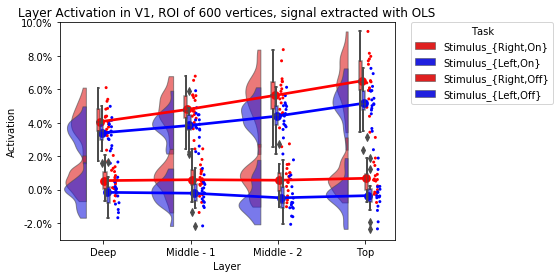

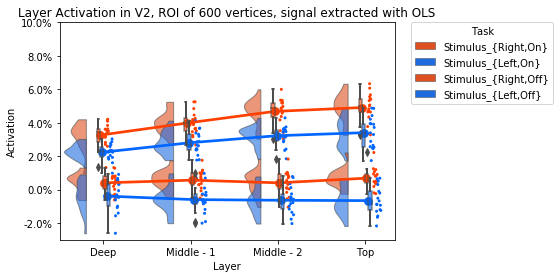

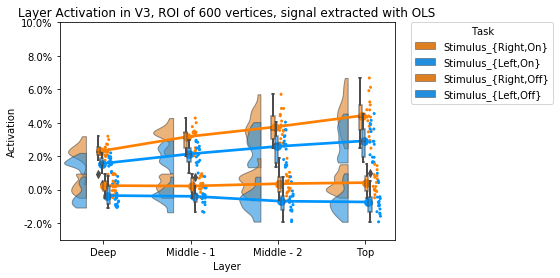

In [11]:
regions = ['V1', 'V2', 'V3']
method = 'OLS'
vertices = [600]
nLayers=4

betas = pd.DataFrame(columns=['Activation', 'Subject', 'Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
for region in regions:
    [a, _] = make_figure(method, vertices[0], region, plot=True, nLayers=nLayers)
    betas = betas.append(a)

aov_table = AnovaRM(betas, 'Activation', 'Subject', within=['Stimulus', 'Attention', 'Layer', 'Hemisphere', 'Area'])
res = aov_table.fit()
group_results["4 Layers,OLS,600"] = res.summary().tables[0]['Pr > F']

In black, p-value above 0.05
In red, p-values below 0.05
In green, p-values below 0.01


In [22]:
selected_columns = ['OLS,600','OLS,300','OLS,900','Interpolation,600','4 Layers,OLS,600']
rows = group_results.index.values
group_results.loc[selected_rows,selected_columns] \
    .style \
    .applymap(bold_face, subset=['OLS,600']) \
    .applymap(color_significant_values) \
    .format({'OLS,300': "{:.4e}", 'OLS,600': "{:.4e}", 'OLS,900': "{:.4e}", 'Interpolation,600': "{:.4e}", '4 Layers,OLS,600': "{:.4e}", })

,"OLS,600","OLS,300","OLS,900","Interpolation,600","4 Layers,OLS,600"
Stimulus,1.6484e-12,5.9542e-13,1.2903e-11,3.7260e-12,2.4967e-13
Attention,1.0325e-08,3.8333e-08,4.1754e-09,9.4821e-09,9.2165e-09
Layer,1.0675e-13,2.8514e-11,7.0133e-13,1.8910e-15,3.2376e-15
Area,1.1341e-08,2.7129e-08,1.1143e-07,1.0199e-08,4.1013e-09
Hemisphere,9.9150e-01,9.4615e-01,9.1015e-01,9.1770e-01,9.0291e-01
Stimulus:Attention,7.3318e-02,2.7104e-01,2.7204e-02,5.5240e-02,1.1797e-02
Stimulus:Layer,1.4331e-13,6.2337e-12,7.2354e-14,8.0025e-15,2.8126e-18
Attention:Layer,8.3352e-10,3.1725e-08,1.9342e-10,7.1005e-12,2.0615e-11
Stimulus:Area,9.4247e-10,2.7865e-08,7.9762e-09,7.4730e-10,1.4493e-10
Attention:Area,7.2539e-02,1.2084e-01,7.7443e-02,1.4068e-01,8.8017e-02
